/var/folders/0l/46n5zz7920jg0lld8ddcxvv40000gn/T/ipykernel_96438/3095480842.py:65: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="news", body=query_body)


,key,doc_count
0,"Musk, Elon",3
1,"Mulvaney, Dylan (1996- )",2
2,"Powell, Jerome H",2
3,"Berchtold, Joe",1
4,"Biden, Joseph R Jr",1


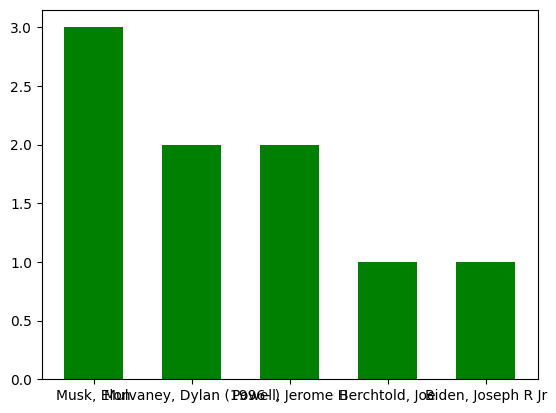

In [1]:
import json
import pandas as pd
from pprint import pprint
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt

def query_agg(section: str, time_scale: str = "yesterday") :

  from elasticsearch import Elasticsearch
  es = Elasticsearch(hosts = "http://@localhost:9200")


  # Top persons mentioned in the articles per year/quarter/month/day, in the section World
  
  if time_scale == "yesterday":
    today = date.today()
    start_date = today - timedelta(days = 1)
    end_date = today

  if time_scale == "week_ago":
    today = date.today()
    start_date = today - timedelta(days = 7)
    end_date = today

  if time_scale == "month_ago":
    today = date.today()
    start_date = today - timedelta(days = 30)
    end_date = today

  query_body = {
    "size": 0,
    "aggs": {
      "filtered_aggregation": {
        "filter": {
          "bool": {
            "filter" : [
              {"terms": {"section": [f"{section}"]}},
              {"range": {"first_published_date": {
                          "gte": f"{start_date}",
                          "lte": f"{end_date}"}}}
            ]
          }
        },
        "aggs": {
          "articles_over_time": {
            "date_histogram": {
              "field": "first_published_date",
              "calendar_interval": "week"
            },
            "aggs": {
              "keywords_in_titles": {
                  "terms": {
                      "field": "per_facet",
                      "size": 5
                    }
                }
            }
          }
        }
      }
    }
  }

  result = es.search(index="news", body=query_body)
  result = json.dumps(result["aggregations"]["filtered_aggregation"]["articles_over_time"]["buckets"][0]["keywords_in_titles"]["buckets"])

  #Pandas.read_json

  df = pd.read_json(result)
  display(df.head())

  plt.bar(df["key"], df["doc_count"] , color = 'green', width = 0.6)
  plt.show()
  #pprint(result.body)



query_agg(section="Business", time_scale="month_ago")